<a href="https://colab.research.google.com/github/Dalia-Sher/Generating-Facial-Expressions-Bidirectional-Conditional-GAN/blob/Shir/9_BiCoWGAN_with_Shear_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, concatenate, Conv2DTranspose, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
import imgaug as ia
import imgaug.augmenters as iaa

In [5]:
!unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [6]:
data = pd.read_csv('fer2013.csv')
data = data[data.emotion != 1]
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
data.shape

(35340, 3)

In [9]:
data['emotion'] = data.emotion.replace(6, 1)

In [10]:
data.emotion.value_counts()

3    8989
1    6198
4    6077
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

In [11]:
dic = {0:'Angry', 1:'Neutral', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise'}

In [12]:
num_classes = 6
img_width = 48
img_height = 48

In [13]:
X = data['pixels']
y = data['emotion']

X_train = []
for i in X:
    X_train.append([int(j) for j in i.split()])

X_train = np.array(X_train)/255.0

X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_train = X_train.astype('float32')

y_train = y.to_numpy().reshape(-1, 1)

print(X_train.shape)

(35340, 48, 48, 1)


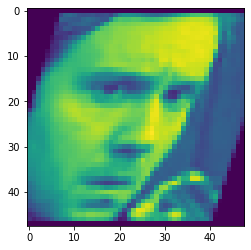

In [14]:
#Shear - 2 new images
img = X_train[0]
shear = iaa.Affine(shear=(0,30))
shear_image=shear.augment_image(img)
plt.imshow(shear_image.squeeze())

In [16]:
#rotating image 
iterations_per_image = 2
X_train_aug = np.copy(X_train)
y_train_aug = np.copy(y_train)
for k in range(len(X_train)):
  img = X_train[k]
  emotion = y_train[k]
  sheared_images = []
  emotions_list = []
  for i in range(iterations_per_image):
    shear = iaa.Affine(shear=(0,30 + i))
    shear_image=shear.augment_image(img)
    sheared_images.append(shear_image)
  sheared_images = np.array(sheared_images)
  X_train_aug = np.concatenate((X_train_aug, sheared_images), axis=0)
  emotions_list = [emotion]*iterations_per_image
  emotions_list = np.array(emotions_list)
  y_train_aug = np.concatenate((y_train_aug, emotions_list), axis=0)
  print("iteration:" , k ,"X train shape:",X_train_aug.shape , "Y train shape:",y_train_aug.shape)

Streaming output truncated to the last 5000 lines.
iteration: 30340 X train shape: (96022, 48, 48, 1) Y train shape: (96022, 1)
iteration: 30341 X train shape: (96024, 48, 48, 1) Y train shape: (96024, 1)
iteration: 30342 X train shape: (96026, 48, 48, 1) Y train shape: (96026, 1)
iteration: 30343 X train shape: (96028, 48, 48, 1) Y train shape: (96028, 1)
iteration: 30344 X train shape: (96030, 48, 48, 1) Y train shape: (96030, 1)
iteration: 30345 X train shape: (96032, 48, 48, 1) Y train shape: (96032, 1)
iteration: 30346 X train shape: (96034, 48, 48, 1) Y train shape: (96034, 1)
iteration: 30347 X train shape: (96036, 48, 48, 1) Y train shape: (96036, 1)
iteration: 30348 X train shape: (96038, 48, 48, 1) Y train shape: (96038, 1)
iteration: 30349 X train shape: (96040, 48, 48, 1) Y train shape: (96040, 1)
iteration: 30350 X train shape: (96042, 48, 48, 1) Y train shape: (96042, 1)
iteration: 30351 X train shape: (96044, 48, 48, 1) Y train shape: (96044, 1)
iteration: 30352 X train 

In [ ]:

X_train = np.concatenate((X_train, X_train_aug), axis=0)
y_train = np.concatenate((y_train, y_train_aug), axis=0)
print(X_train.shape)
print(y_train.shape)

In [18]:
class BiCoGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 48
        self.img_cols = 48
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 6
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        print(self.discriminator.summary())
        plot_model(self.discriminator, show_shapes=True)
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the encoder
        self.encoder = self.build_encoder()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        label = Input(shape=(1,))

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Generate image from sampled noise
        z = Input(shape=(self.latent_dim, ))
        img_ = self.generator([z, label])

        # Encode image
        img = Input(shape=self.img_shape)
        z_ = self.encoder(img)

        # Latent -> img is fake, and img -> latent is valid
        fake = self.discriminator([z, img_, label])
        valid = self.discriminator([z_, img, label])

        # Set up and compile the combined model
        # Trains generator to fool the discriminator
        self.bicogan_generator = Model([z, img, label], [fake, valid])
        self.bicogan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            optimizer=optimizer)

    def build_encoder(self):
        model = Sequential()

        # model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.25))
        # model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        # model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.25))
        # model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.25))
        # model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.25))
        # model.add(Flatten())
        # model.add(Dense(self.latent_dim))


        model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=self.img_shape))
        model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Flatten())
        model.add(Dense(self.latent_dim))

        # model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=self.img_shape))
        # model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
        # model.add(BatchNormalization(momentum=0.9))
        # model.add(Conv2D(256, (4,4), strides=(2,2), padding='same'))
        # model.add(BatchNormalization(momentum=0.9))
        # model.add(Conv2D(512, (4,4), strides=(2,2), padding='same'))
        # model.add(BatchNormalization(momentum=0.9))
        # model.add(Flatten())
        # model.add(Dense(self.latent_dim))

        # model.add(Flatten(input_shape=self.img_shape))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(self.latent_dim))

        print('encoder')
        model.summary()

        img = Input(shape=self.img_shape)
        z = model(img)

        return Model(img, z)

    def build_generator(self):

        model = Sequential()
        # foundation for 12x12 image
        n_nodes = 128 * 12 * 12
        model.add(Dense(n_nodes, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((12, 12, 128)))
        # upsample to 24x24
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 48x48
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # generate
        model.add(Conv2D(1, (12, 12), activation='tanh', padding='same'))

        # model = Sequential()
        # # foundation for 3x3 feature maps
        # n_nodes = 128 * 3 * 3
        # model.add(Dense(n_nodes, input_dim=self.latent_dim))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Reshape((3, 3, 128)))
        # # upsample to 6x6
        # model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        # model.add(LeakyReLU(alpha=0.2))
        # # upsample to 12x12
        # model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        # model.add(LeakyReLU(alpha=0.2))
        # # upsample to 24x24
        # model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        # model.add(LeakyReLU(alpha=0.2))
        # # upsample to 48x48
        # model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        # model.add(LeakyReLU(alpha=0.2))
        # # output layer 48x48x1
        # model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))

        # model.add(Dense(256, input_dim=self.latent_dim))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(1024))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        # model.add(Reshape(self.img_shape))

        print('generator')
        model.summary()

        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([z, label_embedding])
        img = model(model_input)

        return Model([z, label], img)

    # def build_discriminator(self):

    #     z = Input(shape=(self.latent_dim, ))
    #     img = Input(shape=self.img_shape)
    #     label = Input(shape=(1,), dtype='int32')

    #     label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
    #     flat_img = Flatten()(img)

    #     d_in = concatenate([z, flat_img, label_embedding])

    #     model = Dense(1024)(d_in)
    #     model = LeakyReLU(alpha=0.2)(model)
    #     model = Dropout(0.5)(model)
    #     model = Dense(1024)(model)
    #     model = LeakyReLU(alpha=0.2)(model)
    #     model = Dropout(0.5)(model)
    #     model = Dense(1024)(model)
    #     model = LeakyReLU(alpha=0.2)(model)
    #     model = Dropout(0.5)(model)
    #     validity = Dense(1, activation="sigmoid")(model)

    #     return Model([z, img, label], validity, name='discriminator')

    def build_discriminator(self):
        xi = Input(self.img_shape)
        zi = Input(self.latent_dim)
        label = Input(shape=(1,), dtype='int32')

        # xn = Conv2D(df_dim, (5, 5), (2, 2), act=lrelu, W_init=w_init)(xi)
        # xn = Conv2D(df_dim * 2, (5, 5), (2, 2), W_init=w_init, b_init=None)(xn)
        # xn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=g_init)(xn)
        # xn = Dropout(keep=0.8)(xn)
        # xn = Conv2d(df_dim * 4, (5, 5), (2, 2), W_init=w_init, b_init=None)(xn)
        # xn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=g_init)(xn)
        # xn = Dropout(keep=0.8)(xn)
        # xn = Conv2d(df_dim * 8, (5, 5), (2, 2), W_init=w_init, b_init=None)(xn)
        # xn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=g_init)(xn)
        # xn = Dropout(keep=0.8)(xn)
        # xn = Flatten()(xn)

        xn = Conv2D(128, (5,5), padding='same')(xi)
        xn = LeakyReLU(alpha=0.2)(xn)
        # downsample to 24x24
        xn = Conv2D(128, (5,5), strides=(2,2), padding='same')(xn)
        xn = LeakyReLU(alpha=0.2)(xn)
        # downsample to 12x12
        xn = Conv2D(128, (5,5), strides=(2,2), padding='same')(xn)
        xn = LeakyReLU(alpha=0.2)(xn)
        # downsample to 6x6
        xn = Conv2D(128, (5,5), strides=(2,2), padding='same')(xn)
        xn = LeakyReLU(alpha=0.2)(xn)
        # downsample to 3x3
        xn = Conv2D(128, (5,5), strides=(2,2), padding='same')(xn)
        xn = LeakyReLU(alpha=0.2)(xn)
        # classifier
        xn = Flatten()(xn)

        zn = Flatten()(zi)
        # zn = Dense(512, activation='relu')(zn)
        # zn = Dropout(0.2)(zn)

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))

        nn = concatenate([zn, xn, label_embedding])
        nn = Dense(1, activation='sigmoid')(nn)

        return Model([zi, xi, label], nn, name='discriminator')


    def train(self, epochs, batch_size=128, sample_interval=50):
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images and encode
            idx = np.random.randint(0, X_train_aug.shape[0], batch_size)
            # imgs = datagen.flow(X_train_2[idx], y_train[idx], batch_size=batch_size)
            # labels = y_train[idx]
            imgs, labels = X_train_aug[idx], y_train_aug[idx]
            z_ = self.encoder.predict(imgs)

            # Sample noise and generate img
            z = np.random.normal(0, 1, (batch_size, 100))
            imgs_ = self.generator.predict([z, labels])

            # Train the discriminator (img -> z is valid, z -> img is fake)
            d_loss_real = self.discriminator.train_on_batch([z_, imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([z, imgs_, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 6, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.bicogan_generator.train_on_batch([z, imgs, sampled_labels], [valid, fake])

            # Plot the progress
            if epoch%20 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)


    def sample_images(self, epoch):
          r, c = 1, 6
          noise = np.random.normal(0, 1, (r * c, 100))
          sampled_labels = np.arange(0, 6).reshape(-1, 1)

          gen_imgs = self.generator.predict([noise, sampled_labels])

          # Rescale images 0 - 1
          gen_imgs = 0.5 * gen_imgs + 0.5

          fig, axs = plt.subplots(r, c)
          cnt = 0
          for j in range(c):
              axs[j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
              axs[j].set_title("%s" % dic[sampled_labels[cnt][0]])
              axs[j].axis('off')
              cnt += 1
          fig.savefig(r"C:\Users\shir2\Desktop\Shir\MSc\Deep_generative_models\project\archive\fer2013\fer2013\%d.png" % epoch)
          plt.close()


In [ ]:
if __name__ == '__main__':
    bicogan = BiCoGAN()
    bicogan.train(epochs=18601, batch_size=128, sample_interval=200)

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 128)  3328        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 48, 48, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 128)  409728      leaky_re_lu[0][0]                
______________________________________________________________________________________